<a href="https://colab.research.google.com/github/beyzahiz/Transfer-Learning-Fruit-Classification/blob/main/Transfer_Learning_Fruit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -n /content/drive/MyDrive/transfer_learning_fruit_dataset/fruits.zip -d /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_17.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_173.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_177.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_181.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_185.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_189.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_193.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspberry 3/r0_197.jpg  
  inflating: /content/fruits-360_original-size/fruits-360-original-size/Validation/Raspber

In [2]:
import os
print(os.listdir("/content"))
print(os.listdir("/content/fruits-360_100x100"))

['.config', 'fruits-360_original-size', 'fruits-360_meta', 'fruits-360_3-body-problem', 'drive', 'fruits-360_100x100', 'fruits-360_multi', 'sample_data']
['fruits-360']


In [3]:
print(os.listdir("/content/fruits-360_100x100"))
print(os.listdir("/content/fruits-360_100x100/fruits-360"))
print(len(os.listdir("/content/fruits-360_100x100/fruits-360/Training")))

['fruits-360']
['Test', 'Training', 'README.md', 'LICENSE']
251


In [4]:
import os

train_path = "/content/fruits-360_100x100/fruits-360/Training"
classes = os.listdir(train_path)

print("Toplam class:", len(classes))
print("İlk 20 class:")
print(classes[:20])

Toplam class: 251
İlk 20 class:
['Apple 8', 'Quince 1', 'Apple 18', 'Banana 3', 'Raspberry 3', 'Cucumber 4', 'Onion Red 3', 'Strawberry 1', 'Blueberry 1', 'Apple Pink Lady 1', 'Grapefruit Pink 1', 'Nut Forest 1', 'Avocado Black 2', 'Mango 1', 'Raspberry 5', 'Pear 10', 'Apple 14', 'Avocado Black 1', 'Tomato 9', 'Pomegranate 1']


In [5]:
import os
import shutil

# Orijinal dataset yolu
base_path = "/content/fruits-360_100x100/fruits-360"
train_path = os.path.join(base_path, "Training")
test_path = os.path.join(base_path, "Test")

# Yeni küçük dataset yolu
small_base = "/content/fruits_small"
small_train = os.path.join(small_base, "Training")
small_test = os.path.join(small_base, "Test")

os.makedirs(small_train, exist_ok=True)
os.makedirs(small_test, exist_ok=True)

# Seçilen 10 class
selected_classes = [
    "Apple Granny Smith 1",
    "Pineapple 1",
    "Raspberry 2",
    "Mandarine 1",
    "Cauliflower 1",
    "Pepper Yellow 1",
    "Pear Williams 1",
    "Cucumber 11",
    "Cherry 5",
    "Nut 4"
]

# Kopyalama işlemi
for cls in selected_classes:
    shutil.copytree(os.path.join(train_path, cls), os.path.join(small_train, cls))
    shutil.copytree(os.path.join(test_path, cls), os.path.join(small_test, cls))

print("Küçük dataset oluşturuldu.")

Küçük dataset oluşturuldu.


In [6]:
print(len(os.listdir("/content/fruits_small/Training")))

10


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/fruits_small/Training"
test_dir = "/content/fruits_small/Test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(  #klasörleri labela çevirir
    train_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical'  #one hot encoding
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical'
)

Found 4933 images belonging to 10 classes.
Found 1648 images belonging to 10 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    weights='imagenet',  #eğitilmiş veri seti yüklenir
    include_top=False,  #son classification katmanları atılır, boş alan açılır
    input_shape=(100,100,3)
)

/tmp/ipython-input-1552/1675241793.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
base_model.trainable = False
#modeli ilk eğitimle bozmak istenmiyor o yüzden freezing yapılıyor
#küçük dataset ile tüm ağı yeniden eğitmek riskli, sadece üst katmanlar eğitilecek

In [11]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 48s 196ms/step - accuracy: 0.9215 - loss: 0.2828 - val_accuracy: 1.0000 - val_loss: 6.0224e-04
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 1.0000 - loss: 1.4224e-04 - val_accuracy: 1.0000 - val_loss: 3.3383e-04
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 1.0000 - loss: 8.0211e-05 - val_accuracy: 1.0000 - val_loss: 2.3787e-04
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.0000 - loss: 5.6976e-05 - val_accuracy: 1.0000 - val_loss: 1.6508e-04
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 1.0000 - loss: 3.6714e-05 - val_accuracy: 1.0000 - val_loss: 1.2385e-04


In [12]:
len(base_model.layers) #kaç layer var

154

In [13]:
#Fine Tuning
# Modelin son katmanlarını açıp tekrardan eğitmek böylece model çok ince detayları daha iyi öğrenmek için güncelleniyor
len(base_model.layers) #kaç layer var

base_model.trainable = True  #bütün katmanlar açılıyor
for layer in base_model.layers[:-20]:  #son 20 katman hariç hepsi yine freezeleniyor
  layer.trainable = False


from tensorflow.keras.optimizers import Adam

model.compile(  #Fine-tuningde büyük learning rate kullanılırsa ImageNet bilgisi bozulur
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=3
)

Epoch 1/3
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.9889 - loss: 0.1402 - val_accuracy: 1.0000 - val_loss: 2.1366e-04
Epoch 2/3
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 2.9462e-04
Epoch 3/3
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9999 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 2.9981e-04


In [14]:
#Data Augmentation

train_datagen_aug = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)

train_generator_aug = train_datagen_aug.flow_from_directory(  #bu kuralları klasördeki dosyalara uygular
    train_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical'
)

Found 4933 images belonging to 10 classes.


In [15]:
base_model.trainable = False #data augmentation sonrası yeni bilgiler görünce bozulablir model
#o yüzden fine tuning kapattım

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history_aug = model.fit(
    train_generator_aug,
    validation_data = test_generator,
    epochs = 5
)

Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - accuracy: 0.9970 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 2.8293e-06
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9992 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.7483e-07
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 1.0000 - loss: 4.2206e-05 - val_accuracy: 1.0000 - val_loss: 6.5680e-08
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 1.0000 - loss: 1.8195e-05 - val_accuracy: 1.0000 - val_loss: 4.0725e-08
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 1.0000 - loss: 3.7949e-06 - val_accuracy: 1.0000 - val_loss: 3.2551e-08


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Gerçek class:  Mandarine 1
Tahmin edilen class:  Mandarine 1


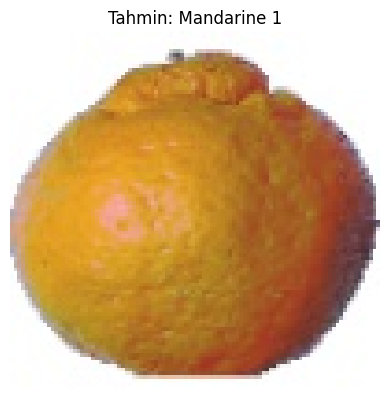

In [16]:
#Test

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

test_dir = "/content/fruits_small/Test"
classes = os.listdir(test_dir)
class_name = random.choice(classes)

#rastgele resim seçme
img_name = random.choice(os.listdir(os.path.join(test_dir, class_name)))
img_path = os.path.join(test_dir, class_name, img_name)

#resmi yükleme
img = image.load_img(img_path, target_size=(100,100))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

#tahmin
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

#class indexi class name e çevirme
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
predicted_class = index_to_class[predicted_class_index]

plt.imshow(img)
plt.title("Tahmin: " + predicted_class)
plt.axis("off")

print("Gerçek class: ", class_name)
print("Tahmin edilen class: ", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tahmin edilen class:  Pineapple 1
Confidence:  0.8307908


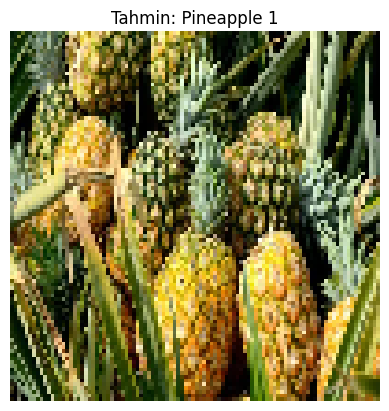

In [18]:
#Distribution Shift
#dataset dışından bir görsel yüklenir böylece model test edilir

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/test.jpg"

img = image.load_img(img_path, target_size=(100,100))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = index_to_class[np.argmax(prediction)]

plt.imshow(img)
plt.title("Tahmin: " + predicted_class)
plt.axis("off")

print("Tahmin edilen class: ", predicted_class)
print("Confidence: ", np.max(prediction)) #softmax çıktısı, olasılık

In [19]:
probs = prediction[0]

for i in range(len(probs)):  #tüm olasılıklar
    print(index_to_class[i], ":", round(probs[i], 3))

Apple Granny Smith 1 : 0.106
Cauliflower 1 : 0.0
Cherry 5 : 0.016
Cucumber 11 : 0.0
Mandarine 1 : 0.003
Nut 4 : 0.0
Pear Williams 1 : 0.041
Pepper Yellow 1 : 0.0
Pineapple 1 : 0.831
Raspberry 2 : 0.001


In [20]:
import numpy as np

test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step


[[15 29 21  6 17  7 14 21 20 14]
 [25 33 23 12 34  9 27 34 22 15]
 [19 28 39 14 26  8 28 27 19 20]
 [12  7  5  6  4  5 12 11  9  7]
 [17 24 29  8 16  6 15 17 14 20]
 [ 6  7  6  7  5  6  8 13 15  6]
 [14 35 22  4 18 12 11 27 10 13]
 [24 24 35 10 16 14 21 37 20 21]
 [23 19 21  7 17  5 15 20 22 17]
 [ 9 28 27  4 13  7 15 15 15 12]]


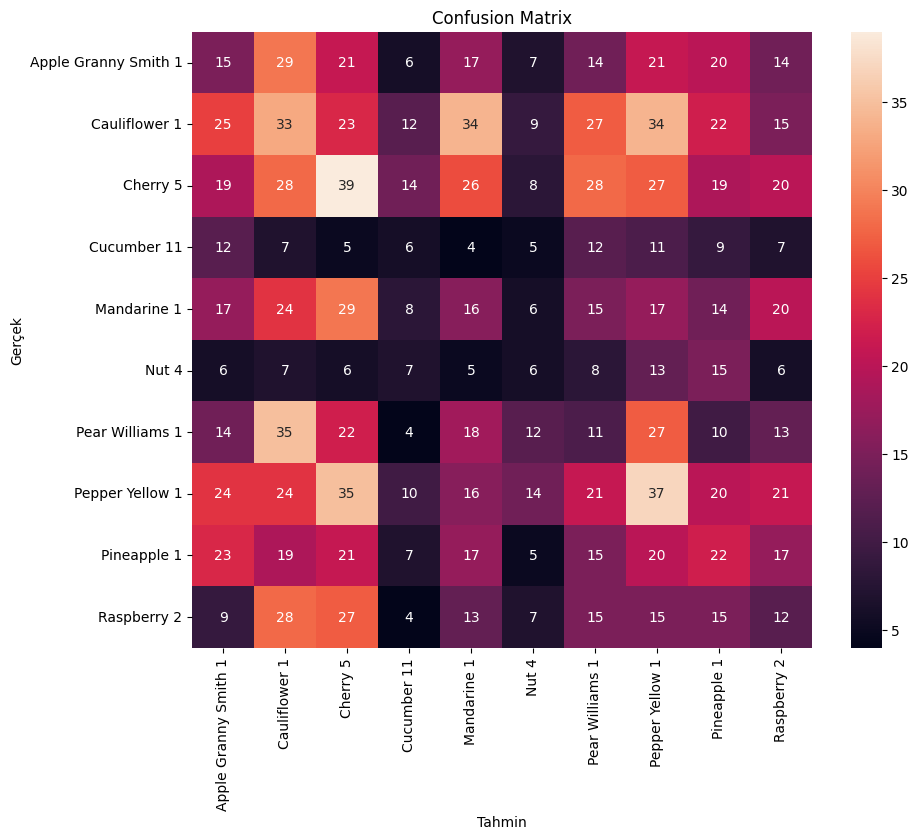

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10,8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()